Analysis of recent coronavirus data for different countries and regions.  
Author: Javier Moldon  
More info in https://github.com/jmoldon/coronavirus_analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates


In [2]:
matplotlib.rcParams["figure.figsize"] = 20,9
import warnings
warnings.filterwarnings('ignore')
do_debug = False

# General statistics

Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily.

In [3]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
data_path = './data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

In [4]:
# Convert date columns to a time series
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
data['mortality_fraction'] = data['Deaths']/data['Confirmed']
data['Province/State'][data['Province/State'].isna()] = ''

In [5]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [6]:
#I need to remove a few points manually that I identified as bad ones
data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Netherlands') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-13', '%Y-%m-%d'))].index, inplace=True)

In [7]:
#data['Country/Region'].unique()

## List of most affected countries (sorted by number of confirmed cases)

In [8]:
data.groupby(['Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Confirmed')[::-1][0:15]

,Confirmed,Deaths,Recovered
Country/Region,,,
China,67790,3075,52960
Italy,21157,1441,1966
Iran,12729,611,2959
"Korea, South",8086,72,510
Spain,6391,195,517
Germany,4585,9,46
France,4469,91,12
Switzerland,1359,13,4
United Kingdom,1140,21,18


## List of most affected countries/provinces (sorted by number of deaths)

In [9]:
data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Deaths')[::-1][0:15]

,,Confirmed,Deaths,Recovered
Country/Region,Province/State,,,
China,Hubei,67790,3075,52960
Italy,,21157,1441,1966
Iran,,12729,611,2959
Spain,,6391,195,517
France,France,4469,91,12
"Korea, South",,8086,72,510
US,Washington,572,37,1
China,Henan,1273,22,1250
Japan,,773,22,118


# Evolution of cases (Confirmed, Deaths, Active and Recovery) per country

All plots have the same information. Left: log scale, right: linear scale. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. 

In [10]:
def select_country(data, country='', province='', start_date='2020-02-15', end_date='2021-03-11', show_numbers=False):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    if show_numbers:
        print('Number of entries per country: {}'.format(cond1.sum()))
        print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

In [11]:
# Functions to fit models to the data, including predictions and confidence interval

def my_exponential(x,  b, alpha, x0):
    return  b * np.exp(alpha * (x-x0))

def my_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def calc_goodness(x, y, func, popt):
    # residual sum of squares
    y_fit = func(x, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def read_fit(popt, pcov, x, y, func, name):
    fit = {}
    fit['popt'] = popt
    fit['pcov'] = pcov
    fit['popt_err'] = np.sqrt(np.diag(pcov))
    fit['goodness'] = calc_goodness(x,y,func,popt)
    fit['func'] = func
    fit['name'] = name
    return fit
    
def choose_optimal_fit(fits):
    fit_names = fits.keys()
    best_goodness = -9999
    for name in fit_names:
        if fits[name]['goodness'] > best_goodness:
            best_goodness = fits[name]['goodness']
            best_fit = fits[name]
    return best_fit

def calc_ci(popt, pcov, xx, func, N=1000):
    popt_err = np.sqrt(np.diagonal(pcov))
    params_sim = np.empty((len(popt), N))
    for i, (p, p_err) in enumerate(zip(popt, popt_err)):
        params_sim[i] = np.random.normal(p, p_err, N)
    y_err = np.empty_like(xx)
    upper_bound = np.empty_like(xx)
    lower_bound = np.empty_like(xx)
    for i, xi in enumerate(xx):
        y_err[i] = np.std(func(xi, *params_sim))
        upper_bound[i] = func(xi, *popt) + y_err[i]
        lower_bound[i] = func(xi, *popt) - y_err[i]
    return upper_bound, lower_bound, y_err

def fit_data(data, future_d=5):
    # Will try to fit a logistic growth. If not possible fit an exponential
    dates = pd.date_range(start=data['DateTime'].iloc[0], end=data['DateTime'].iloc[-1]+datetime.timedelta(days=future_d))
    prediction = pd.DataFrame({'DateTime':dates})
    xx = mdates.date2num(dates)
    for column in ['Confirmed', 'Deaths', 'Recovered']:
        if do_debug:
            print(column)
        x = mdates.date2num(data['DateTime'])
        y = data[column].values
        fits = {}
        try:
            name = 'logistic'
            popt, pcov = curve_fit(my_logistic, x, y, p0=(np.max(y), 1, int(np.mean(x))))
            fits[name] = read_fit(popt, pcov, x, y, my_logistic, name)
            if do_debug:
                print('logistic.    Column: ', column, ' Goodness: ', fits['logistic']['goodness'])
        except RuntimeError:
            pass
        try:
            name = 'exponential'
            popt, pcov = curve_fit(my_exponential, x, y, p0=(np.max(y), 1, np.mean(x)))
            fits[name] = read_fit(popt, pcov, x, y, my_exponential, name)
            if do_debug:
                print('exponential. Column: ', column, ' Goodness: ', fits['exponential']['goodness'])
        except RuntimeError:
            pass
        best_fit = choose_optimal_fit(fits)
        if do_debug:
            print('best', best_fit['name'], best_fit['goodness'])
        data.loc[:, column+'_fit'] = best_fit['func'](x, *best_fit['popt'])
        upper_bound, lower_bound, y_err = calc_ci(best_fit['popt'], best_fit['pcov'], xx, best_fit['func'])
        prediction[column+'_pred'] = best_fit['func'](xx, *best_fit['popt'])
        prediction[column+'_pred_upper'] = upper_bound
        prediction[column+'_pred_lower'] = lower_bound
        # With low number of data points the error can be huge, I will remove the
        # confidence interval when any of the fitted parameters have huge errors:
        if do_debug:
            print()
            print('popt     ', best_fit['popt'])
            print('popt_err ', best_fit['popt_err'])
            print('popt_err/popt ', best_fit['popt_err']/best_fit['popt'])
        if ((best_fit['popt_err']/best_fit['popt']) > 1).any():
            prediction[column+'_pred_upper'] *= np.nan
            prediction[column+'_pred_lower'] *= np.nan
    return data, prediction



In [12]:
def plot_country(data, country='Spain', province='', start_date='2020-02-15', end_date='2021-03-12', show_numbers=False):
    data_country, prediction = fit_data(select_country(data, country=country, province=province, start_date=start_date, end_date=end_date, show_numbers=show_numbers))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(18, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=3)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (2, 1))
    plt.subplots_adjust(hspace=0)

    colors = {'Confirmed': '#3498db',
              'Deaths': 'tomato',
              'Recovered': 'g',
               'Active': 'k'}
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color=colors['Confirmed'], label='Confirmed')
        ax.plot(data_country['DateTime'], data_country['Deaths'],    'o', color=colors['Deaths'], label='Deaths')
        ax.plot(data_country['DateTime'], data_country['Recovered'], 'o', color=colors['Recovered'], label='Recovered')
        ax.plot(data_country['DateTime'], data_country['Active'],    'o', color=colors['Active'], label='Active')    
        ax.plot(data_country['DateTime'], data_country['Recovered_fit'], '-', color=colors['Recovered'])
        ax.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color=colors['Confirmed'])
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'],    '-', color=colors['Deaths'])
        # Model and prediction
        for column in ['Confirmed', 'Deaths', 'Recovered']:
            ax.plot(prediction['DateTime'], prediction[column+'_pred'], '--', color=colors[column])
            ax.fill_between(prediction['DateTime'], prediction[column+'_pred_upper'], prediction[column+'_pred_lower'], color=colors[column], alpha=0.5)
    # Active
    active_fit = data_country['Confirmed_fit']-data_country['Recovered_fit']-data_country['Deaths_fit']
    active_pred = prediction['Confirmed_pred']-prediction['Recovered_pred']-prediction['Deaths_pred']    
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], active_fit,                '-', color=colors['Active'])    
        ax.plot(prediction['DateTime'], active_pred, '--', color=colors['Active'])

    ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    ax1.set_ylim(0.5,1e5)

    ax1.set_ylabel('Number of cases (log scale)')
    ax2.set_ylabel('Number of cases (linear scale)')
    ax3.set_ylabel('Zoom')
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax1.grid()

    fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=150)
    return data_country

## Early onset: China regions

Most of the regions have almost completed the cycle and active cases are disappearing. Note that China Hubei (the original area) has a large number of confirmed cases (70000), but the other regions have very low number of cases, with number around 1200-500 or even less.

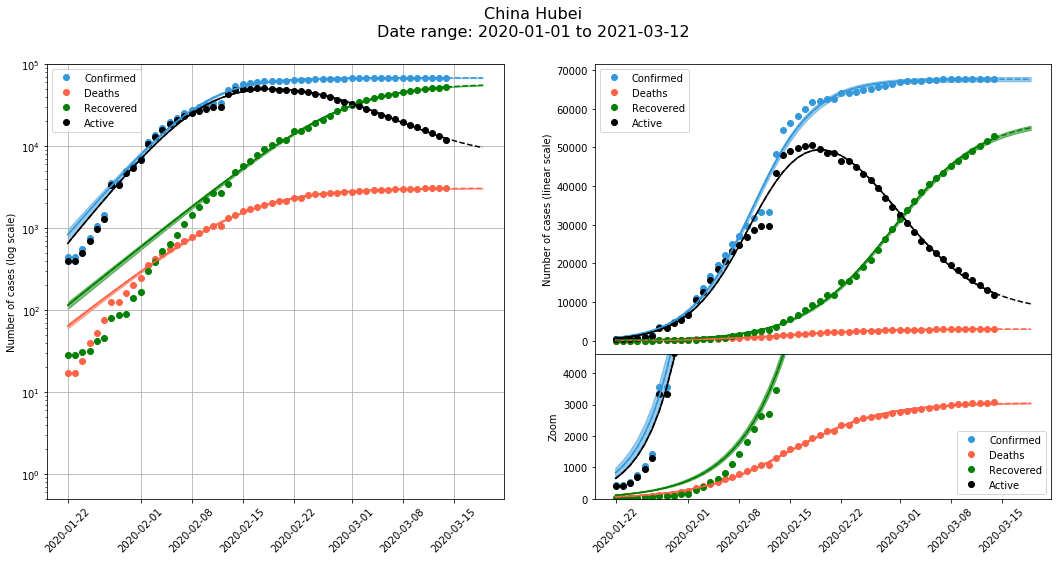

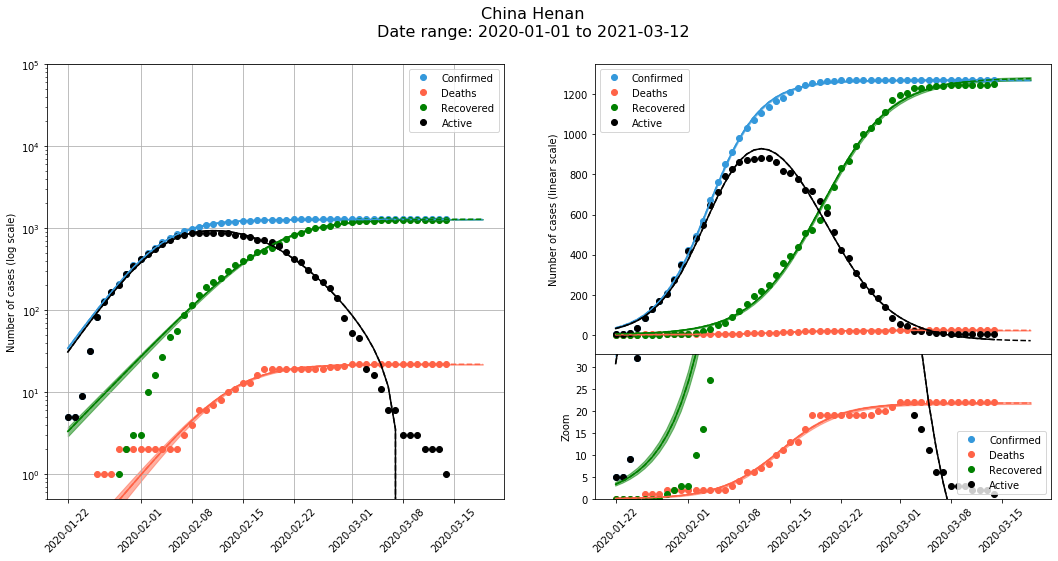

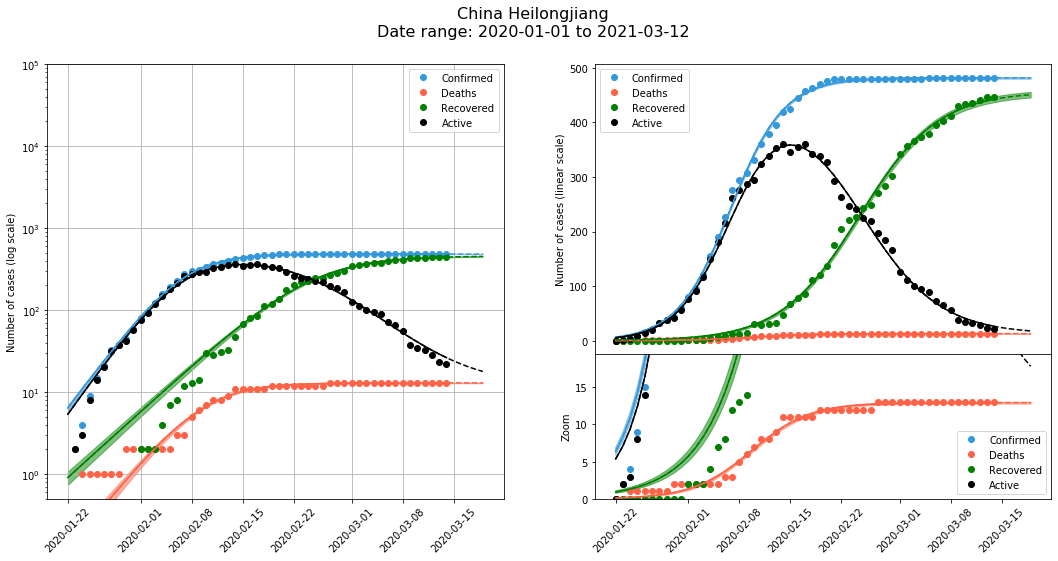

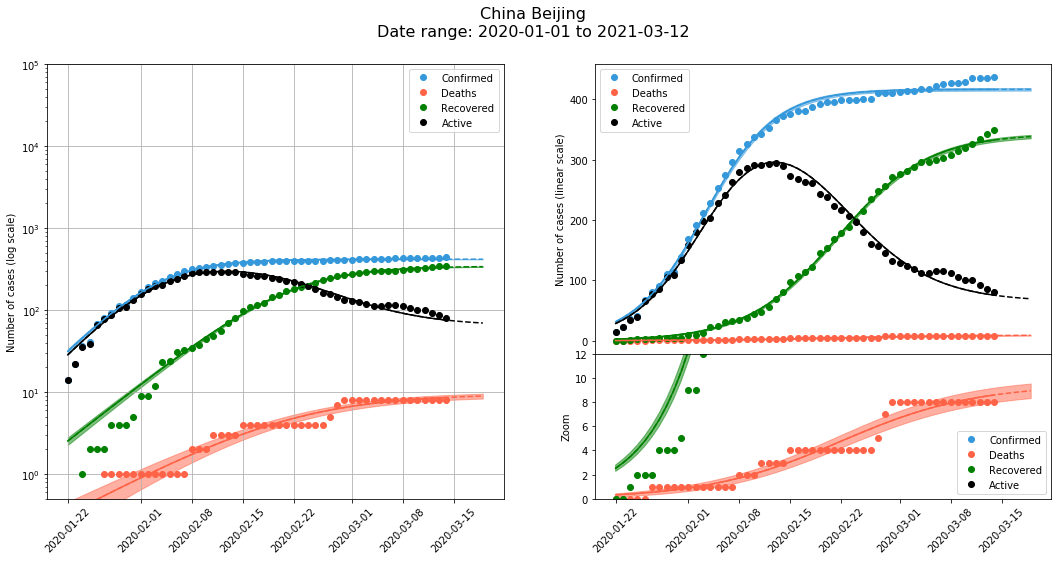

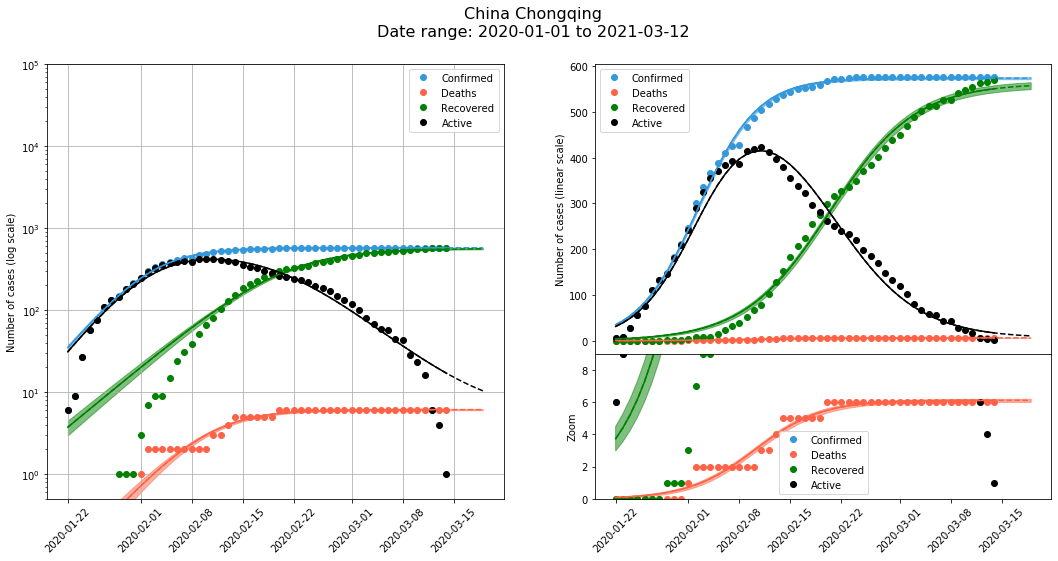

In [13]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:10].index
for i in idx:
    country, province = i
    if country == 'China':
        plot_country(data, country=country, province=province, start_date='2020-01-01', show_numbers=False)

## Europe

The number of confirmed cases and deaths is very high in countries like Italy, Spain and France. Note high rate of deaths, much higher than in , which is still in very exponential stage with some signs of flattening.

In general, more days will be needed for a more accurate fit and prediction, but we are still in a high-growth phase.  
2020-03-15: Italy seems to start showing a flattening of the Death curve, finally!  

2020-03-15: Spain shows a weird behaviour in the early Confirmed cases. For all countries, the first data points are below the fitted curve, but Spain is the other way, and there seems to be a change in the rate of new cases on about March 07. Something happened a week before to cause this significant change?

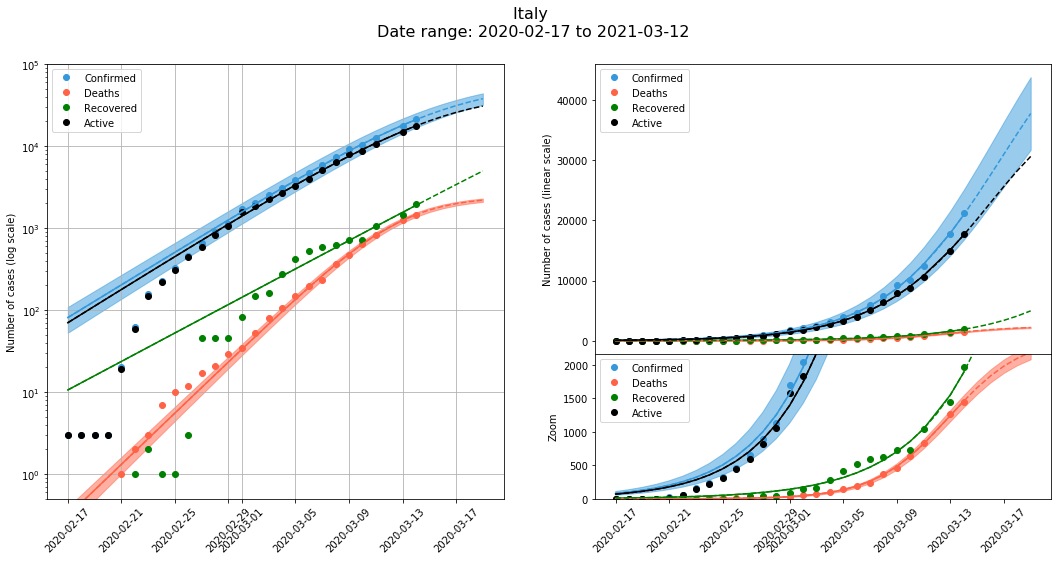

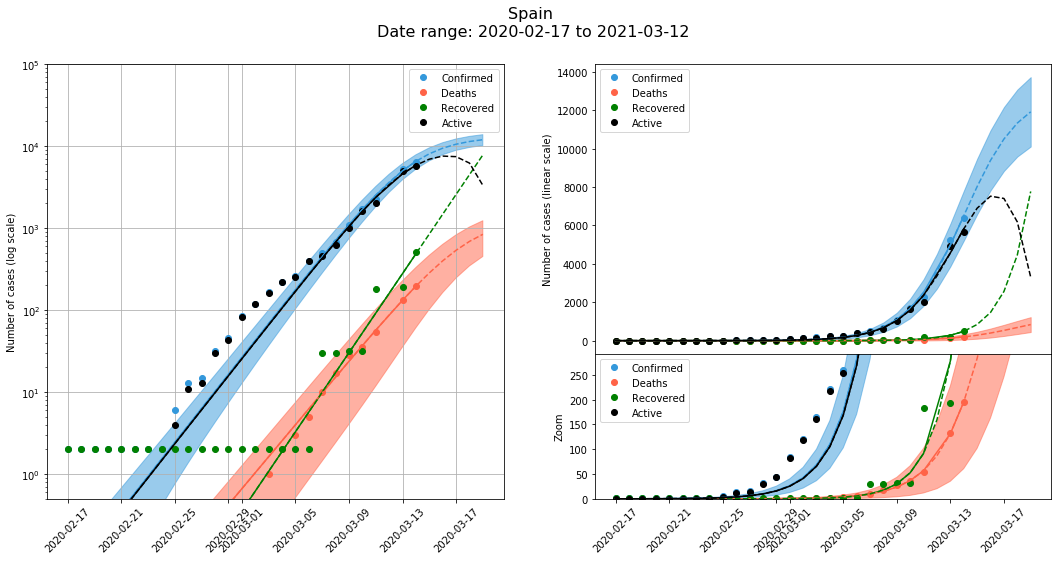

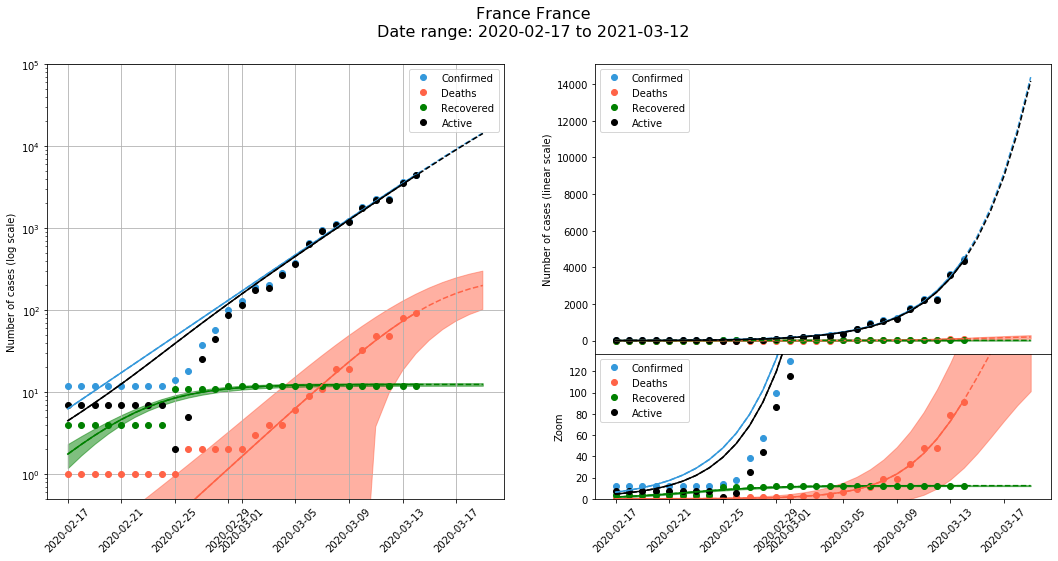

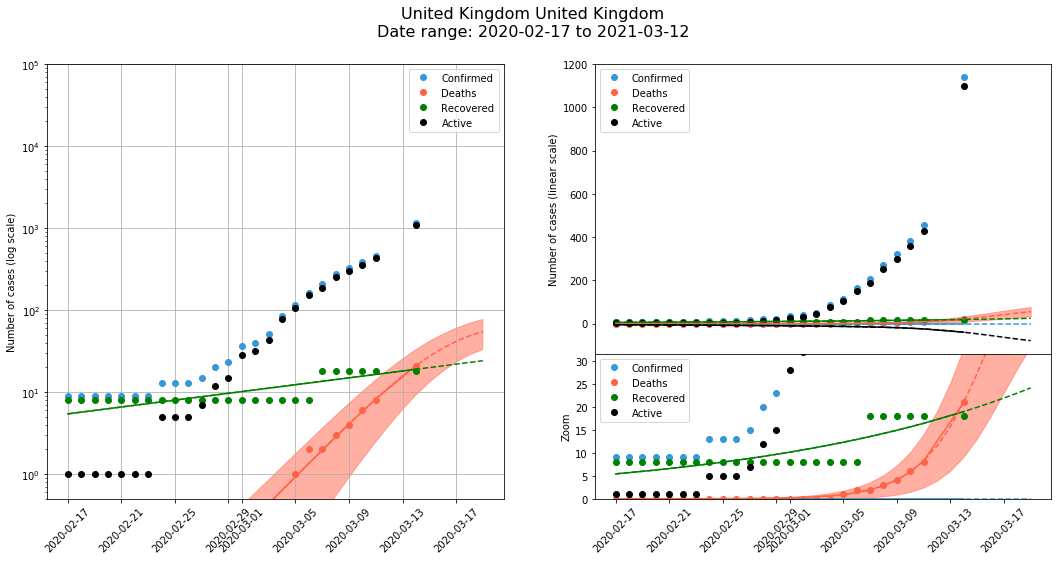

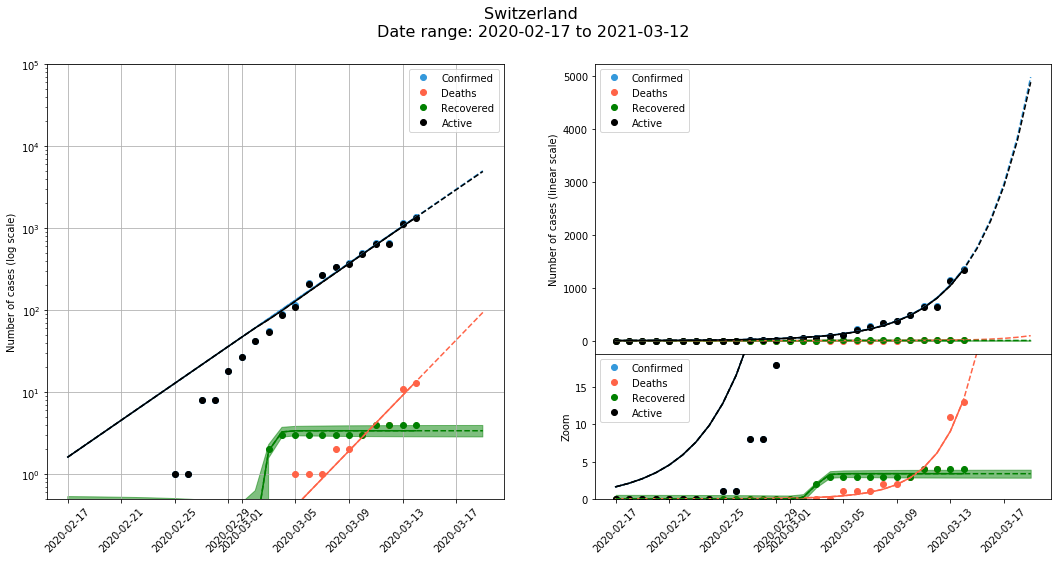

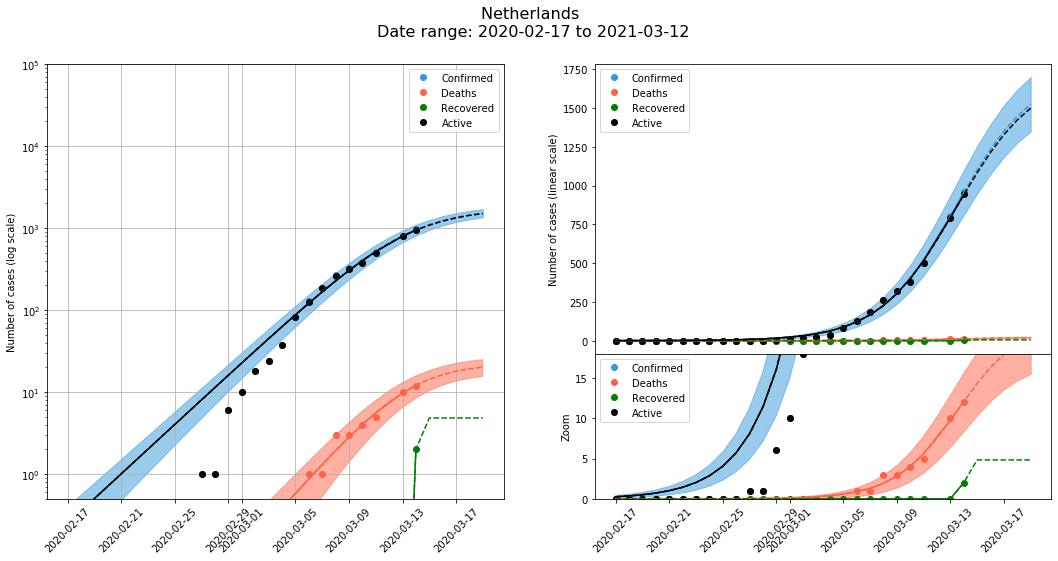

In [14]:
europe_list = [
    ['Italy', ''],
    ['Spain', ''],
    ['France', 'France'],
    ['United Kingdom', 'United Kingdom'],
    ['Switzerland', ''],
    ['Netherlands', '']
]
for country, province in europe_list:
    plot_country(data, country=country, province=province, start_date='2020-02-17', show_numbers=False)

## Other countries in Asia

South Korea has a remarkable recovery rate, with many cases and a reduced number of deaths. Japan growth is moderate, much smaller than in European countries. Iran is showing hints of flattening, although it is curious that the number of recoveries has significantly slowed down while the number of deaths still follow a very exponential trend.

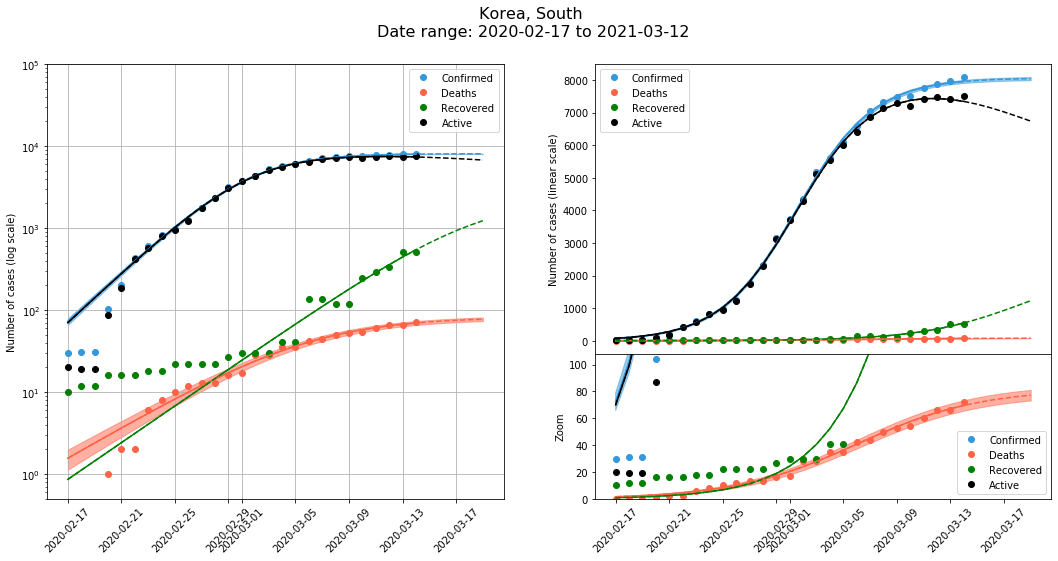

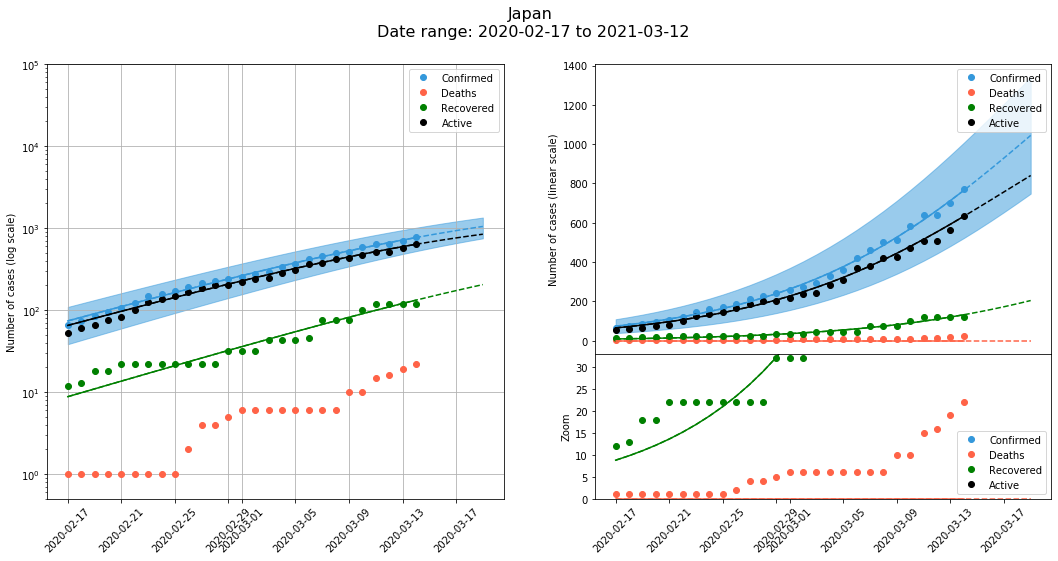

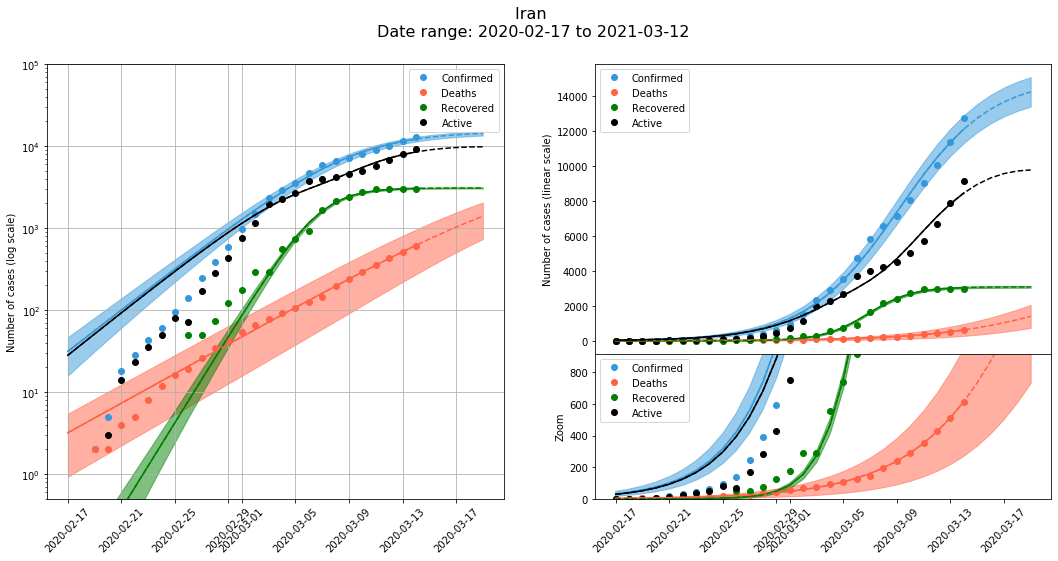

In [15]:
europe_list = [
    ['Korea, South', ''],
    ['Japan', ''],
    ['Iran', '']
]
for country, province in europe_list:
    plot_country(data, country=country, province=province, start_date='2020-02-17', show_numbers=False)

# United States

The number of days with cases is still very low, and the fits are not very informative.

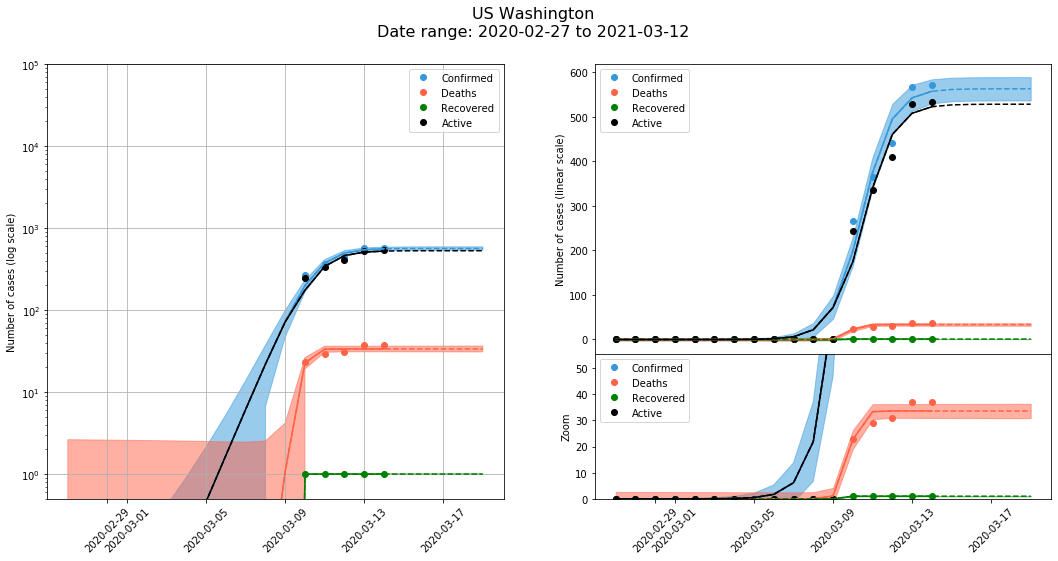

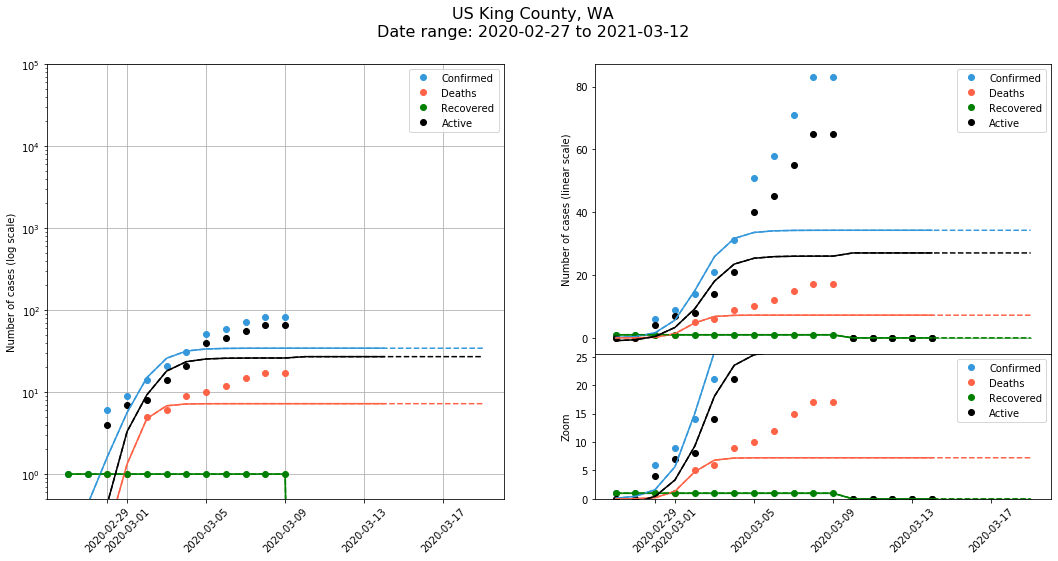

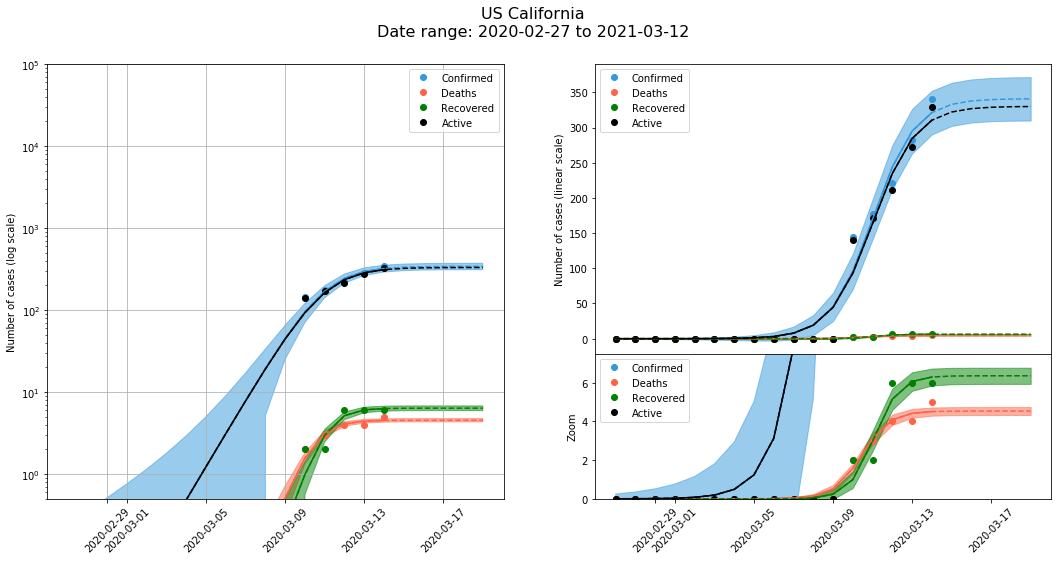

In [16]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:50].index
for i in idx:
    country, province = i
    if country == 'US':
        plot_country(data, country=country, province=province, start_date='2020-02-27', show_numbers=False)

# Comparison of two countries, with a manual time delay to align them

In [17]:
def compare_countries(data, country1='Spain', province1='', start_date1='2020-02-15', end_date1='2021-03-12',
                       country2='Spain', province2='', start_date2='2020-01-15', end_date2='2021-03-12',
                       delay=0, show_numbers=False):
    data_country1, prediction1 = fit_data(select_country(data, country=country1, province=province1, start_date=start_date1, end_date=end_date1, show_numbers=False))
    data_country2, prediction2 = fit_data(select_country(data, country=country2, province=province2, start_date=start_date2, end_date=end_date2, show_numbers=False))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    plt.subplots_adjust(hspace=0)
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1+' Confirmed')
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2+' Confirmed')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1+' Deaths')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2+' Deaths')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax1.set_yscale('log')
    
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2)
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k') 
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1)
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2)
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax3.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1)
    ax3.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    
    ax1.legend()
    ax1.set_ylim(0.5,1e4)
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)

    fig.suptitle(f'{country1} vs {country2}\nTime delay added: {delay} days', fontsize=16)
    fig.savefig(f'./plots/{country1}{province1}_{country2}{province2}.png', bbox_inches='tight', dpi=150)

    

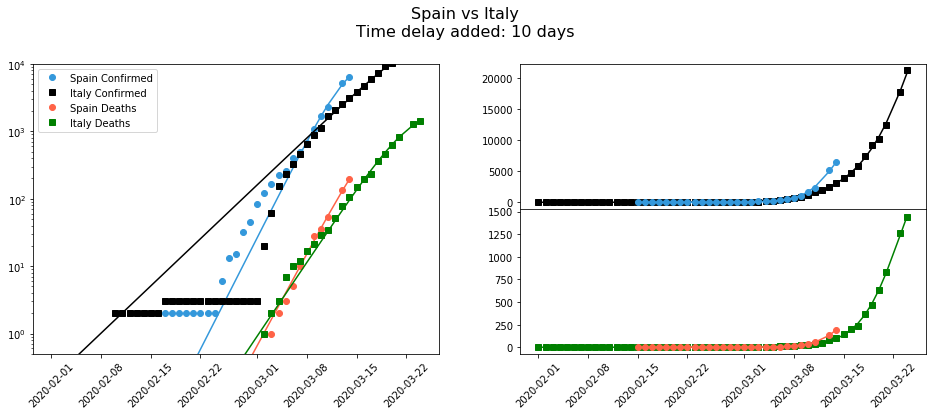

In [18]:
compare_countries(data, country2='Italy', delay=10, show_numbers=False)

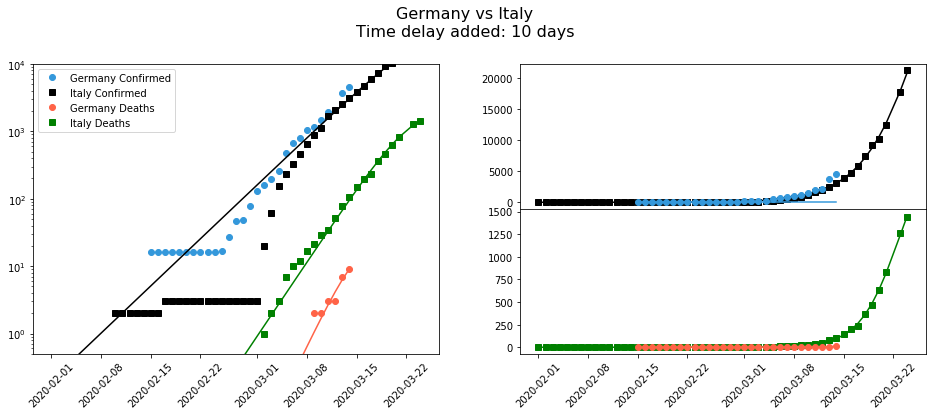

In [19]:
compare_countries(data, country1='Germany', country2='Italy', delay=10)

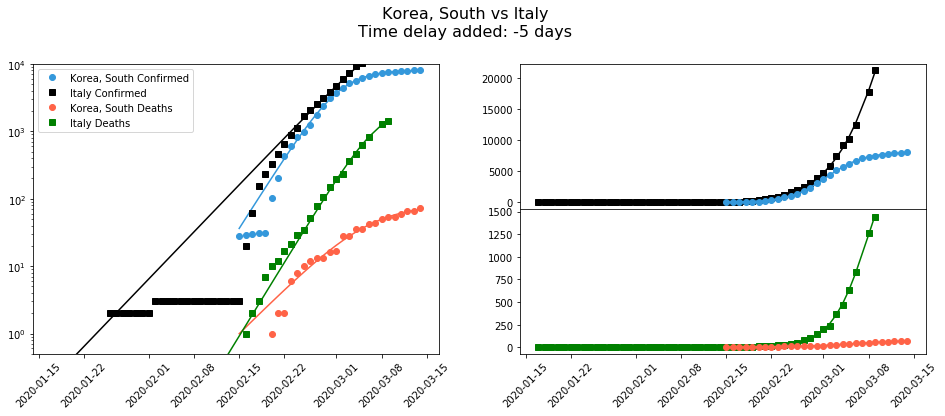

In [20]:
compare_countries(data, country1='Korea, South', country2='Italy', delay=-5)

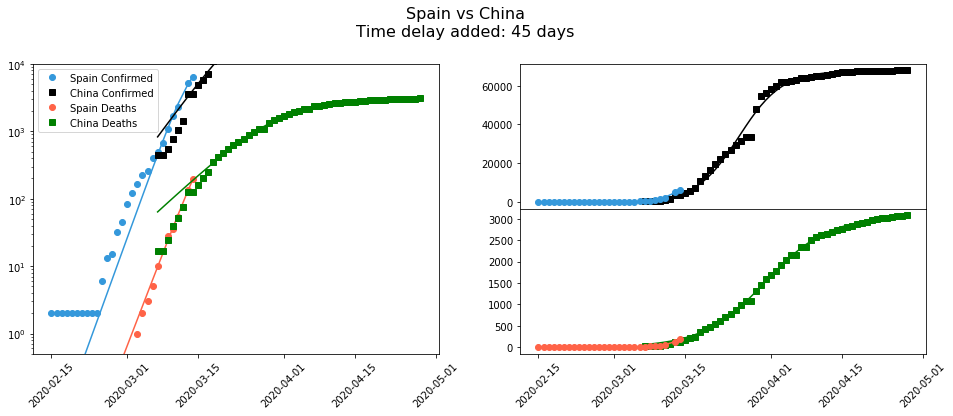

In [21]:
compare_countries(data, country1='Spain', country2='China', province2='Hubei', delay=45)